# Connect drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install and load libraries

In [4]:
!pip install librosa

In [5]:
from glob import glob
import shutil
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

# Download LibriSpeech dataset

In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz
!wget https://www.openslr.org/resources/12/test-clean.tar.gz

--2023-07-09 19:26:30--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/12/train-clean-100.tar.gz [following]
--2023-07-09 19:26:30--  http://us.openslr.org/resources/12/train-clean-100.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G   125MB/s    in 38s     

2023-07-09 19:27:08 (160 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]

--2023-07-09 19:27:09--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)

In [ ]:
!tar -xzf "/content/train-clean-100.tar.gz"
!tar -xzf "/content/dev-clean.tar.gz"
!tar -xzf "/content/test-clean.tar.gz"

In [ ]:
!rm '/content/train-clean-100.tar.gz'
!rm '/content/dev-clean.tar.gz'
!rm '/content/test-clean.tar.gz'

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/dataset/LibriSpeech/train-clean-100'
DEV_PATH = '/content/drive/MyDrive/dataset/LibriSpeech/dev-clean'
TEST_PATH = '/content/drive/MyDrive/dataset/LibriSpeech/test-clean'
ALL_PATH = [TRAIN_PATH, DEV_PATH, TEST_PATH]

**Loading path_file in data**

In [ ]:
#Finding all files in a directory.
list_paths=[]
for path in ALL_PATH:
    for r, d, f in os.walk(path):
        for file in f:
            if '.flac' in file: list_paths.append(os.path.join(r, file))

# Define function use to load data, label and feature extraction.

In [ ]:
def wav2mfcc(file_path, max_pad_len=196):
    ''' convert wav file to mfcc matrix with truncation and padding '''
    wave, sample_rate = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(y=wave, sr=sample_rate)
    mfcc = mfcc[:, :max_pad_len]
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

def extract_mfcc(file_path):
    ''' returns 3D tensor of the mfcc coding from the wav file '''
    file_name = bytes.decode(file_path.numpy())
    mfcc = tf.convert_to_tensor(wav2mfcc(file_name))
    mfcc = tf.expand_dims(mfcc, 2)
    return mfcc

def create_audio_ds(list_ds):
    ''' creates audio dataset containing audio tensors from file list dataset '''
    batch = []
    for f in list_ds:
        audio = extract_mfcc(f)
        batch.append(audio)
    return tf.data.Dataset.from_tensor_slices(batch)

In [ ]:
# def is_valid(file_path):
#     ''' returns True if a regular files. False for hidden files.
#     Also, True is a known user with a name, False if anon.
#     '''
#     file_name = tf.strings.split(file_path, '/')[-1]
#     if tf.strings.substr(file_name, 0, 1) == tf.constant(b'.'):
#         return False
#     sc = tf.strings.split(file_path, '/')[-3]
#     speaker = tf.strings.split(sc, '-')[0]
#     return not tf.strings.substr(speaker, 0, 9) == tf.constant(b'anonymous')

def extract_speaker(file_path):
    ''' extract speaker name from the file path '''
    sc = tf.strings.split(file_path, '/')[-1]
    return tf.strings.split(sc, '-')[0]

def encoding_speaker(speaker_ds):
    '''
    '''
    # create one-hot vector dataset from speakers
    speaker_encoder = preprocessing.LabelEncoder()
    speaker_idx = speaker_encoder.fit_transform([bytes.decode(s.numpy()) for s in speaker_ds])
    encoded_speaker_ds = tf.data.Dataset.from_tensor_slices(speaker_idx)
    unique_speakers = len(speaker_encoder.classes_)
    return encoded_speaker_ds, speaker_encoder, unique_speakers

def load_data(list_path):
    '''
    Return dataset which containing audio tensors and label
    '''
    list_ds = tf.data.Dataset.list_files(list_path,shuffle=False)
    # list_ds = list_ds.filter(is_valid)
    # for f in list_ds.take(3):
    #    print(f.numpy())

    # each folder under root contains audio files for a speaker.
    # the folder name is the name of the speaker plus date and three digit code separated by dash.
    # let's print few sample speaker names.
    speaker_ds = list_ds.map(extract_speaker)
    # for speaker in speaker_ds.take(3):
    #    print(speaker)
    return list_ds, speaker_ds

def train_dev_test_split(labeled_ds, batch_size=32):
    '''
    '''
    # create train, validation and test datasets.
    data_size = sum([1 for _ in labeled_ds])
    train_size = int(data_size * 0.7)
    val_size = int(data_size * 0.2)
    test_size = data_size - train_size - val_size
    print('all samples: {}'.format(data_size))
    print('training samples: {}'.format(train_size))
    print('validation samples: {}'.format(val_size))
    print('test samples: {}'.format(test_size))

    # create batched datasets
    labeled_ds = labeled_ds.shuffle(data_size, seed=42)
    train_ds = labeled_ds.take(train_size).shuffle(1000).batch(batch_size).prefetch(1)
    val_ds = labeled_ds.skip(train_size).take(val_size).batch(batch_size).prefetch(1)
    test_ds = labeled_ds.skip(train_size + val_size).take(test_size).batch(batch_size).prefetch(1)
    return train_ds, val_ds, test_ds

# Loading and extract features

In [ ]:
list_ds, speaker_ds = load_data(list_paths)
encoded_speaker_ds, speaker_encoder, unique_speakers = encoding_speaker(speaker_ds)

In [ ]:
from datetime import datetime
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [ ]:
# Audio (input) tensor is 3D tensor.
# 20x196 is MFCC encoding. Converting it to 3D for use in CNN layers.
# %time
audio_ds = create_audio_ds(list_ds)
# for a in audio_ds.take(1):
#     print(a.numpy().shape)

In [ ]:
# Code to see how long it took
print(datetime.now() - startTime)

0:27:27.185186


**Saving the data, which are converted to 3D matrix and extracted features, we will use them in the future.**

In [ ]:
audio_ds_path = '/content/drive/MyDrive/audio_ds'
tf.data.experimental.save(audio_ds,audio_ds_path)
# new_dataset = tf.data.experimental.load(audio_ds_path)

**Combine each 3D matrix data with it's label.**

In [ ]:
# Finally, zip the input and labels to a single dataset.
complete_labeled_ds = tf.data.Dataset.zip((audio_ds, encoded_speaker_ds))

In [ ]:
# complete_labeled_ds_path = 'complete_labeled_ds'
# tf.data.experimental.save(complete_labeled_ds,complete_labeled_ds_path)

**Split dataset to training, validation and test set.**

In [ ]:
BATCH_SIZE = 32
train_ds, val_ds, test_ds = train_dev_test_split(complete_labeled_ds, BATCH_SIZE)

input_shape = None
for audio, speaker in complete_labeled_ds.take(1):
    input_shape = audio.shape
    print('input_shape', audio.shape)
    print('output_shape', speaker.shape)

all samples: 33862
training samples: 23703
validation samples: 6772
test samples: 3387
input_shape (20, 196, 1)
output_shape ()


# Model

In [ ]:
def create_model(input_shape, unique_speakers):
    dropout_rate = .25
    regularazation = 0.001
    audio_input = keras.layers.Input(shape=input_shape)
    conv1 = keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same',
                               activation='relu', input_shape=input_shape)(audio_input)
    maxpool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
    batch1 = keras.layers.BatchNormalization()(maxpool1)
    conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same',
                               activation='relu', input_shape=input_shape)(batch1)
    maxpool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    batch2 = keras.layers.BatchNormalization()(maxpool2)
    conv3 = keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same',
                activation='relu')(batch2)
    maxpool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    batch3 = keras.layers.BatchNormalization()(maxpool3)
    flt = keras.layers.Flatten()(batch3)
    drp1 = keras.layers.Dropout(dropout_rate)(flt)
    dense1 = keras.layers.Dense(unique_speakers * 2, activation='relu',
                kernel_regularizer=keras.regularizers.l2(regularazation))(drp1)
    drp2 = keras.layers.Dropout(dropout_rate)(dense1)
    output = keras.layers.Dense(unique_speakers, activation='softmax', name='speaker')(drp2)
    model = keras.Model(inputs=audio_input, outputs=output)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['acc'])
    return model

In [ ]:

train_model = False
model_name = 'spr_model.h5'
model_path = os.path.join('.', model_name)
model = None
if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
else:
    model = create_model(input_shape,unique_speakers)
    train_model = True

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 196, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 196, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 98, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 98, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 98, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 49, 32)        0     

In [ ]:

# if training, you can view the tensorboard.
# type on command line to start tensorboard: tensorboard --logdir=./spr_logs --port=6006
# view details: http://localhost:6006
if train_model:
    root_logdir = os.path.join(os.curdir, "spr_logs")
    def get_run_dir():
        import time
        run_id = time.strftime("run%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)
    run_logdir = get_run_dir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, update_freq='batch')
    history = model.fit(train_ds, epochs=8, validation_data=val_ds, callbacks=[tensorboard_cb])


Epoch 1/8
741/741 [==============================] - 72s 92ms/step - loss: 4.2048 - acc: 0.2995 - val_loss: 2.1452 - val_acc: 0.6586
Epoch 2/8
741/741 [==============================] - 79s 105ms/step - loss: 1.8421 - acc: 0.7417 - val_loss: 1.2811 - val_acc: 0.9037
Epoch 3/8
741/741 [==============================] - 69s 91ms/step - loss: 1.4112 - acc: 0.8530 - val_loss: 1.1699 - val_acc: 0.9161
Epoch 4/8
741/741 [==============================] - 69s 90ms/step - loss: 1.2573 - acc: 0.8863 - val_loss: 1.0430 - val_acc: 0.9525
Epoch 5/8
741/741 [==============================] - 68s 90ms/step - loss: 1.1816 - acc: 0.9023 - val_loss: 0.9895 - val_acc: 0.9640
Epoch 6/8
741/741 [==============================] - 73s 97ms/step - loss: 1.1255 - acc: 0.9154 - val_loss: 0.9309 - val_acc: 0.9696
Epoch 7/8
741/741 [==============================] - 68s 91ms/step - loss: 1.0977 - acc: 0.9174 - val_loss: 0.9511 - val_acc: 0.9674
Epoch 8/8
741/741 [==============================] - 72s 96ms/step -

In [ ]:
model.evaluate(test_ds)

106/106 [==============================] - 3s 21ms/step - loss: 0.9123 - acc: 0.9557


[0.9123402237892151, 0.9557130336761475]

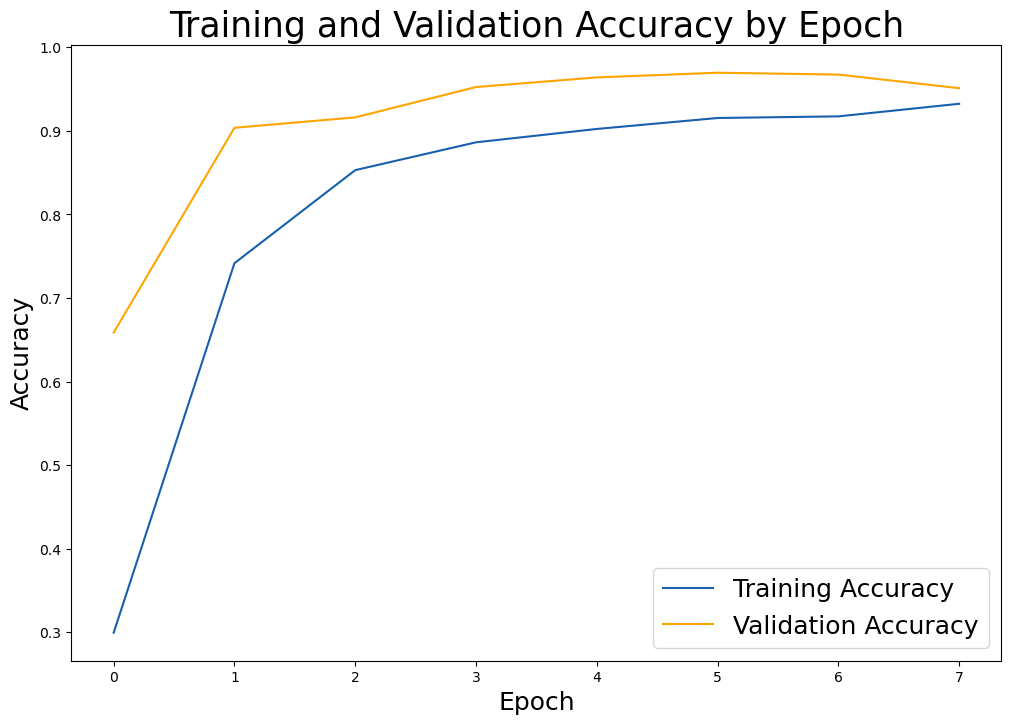

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(0,8,1), range(0,8,1))

plt.legend(fontsize = 18)

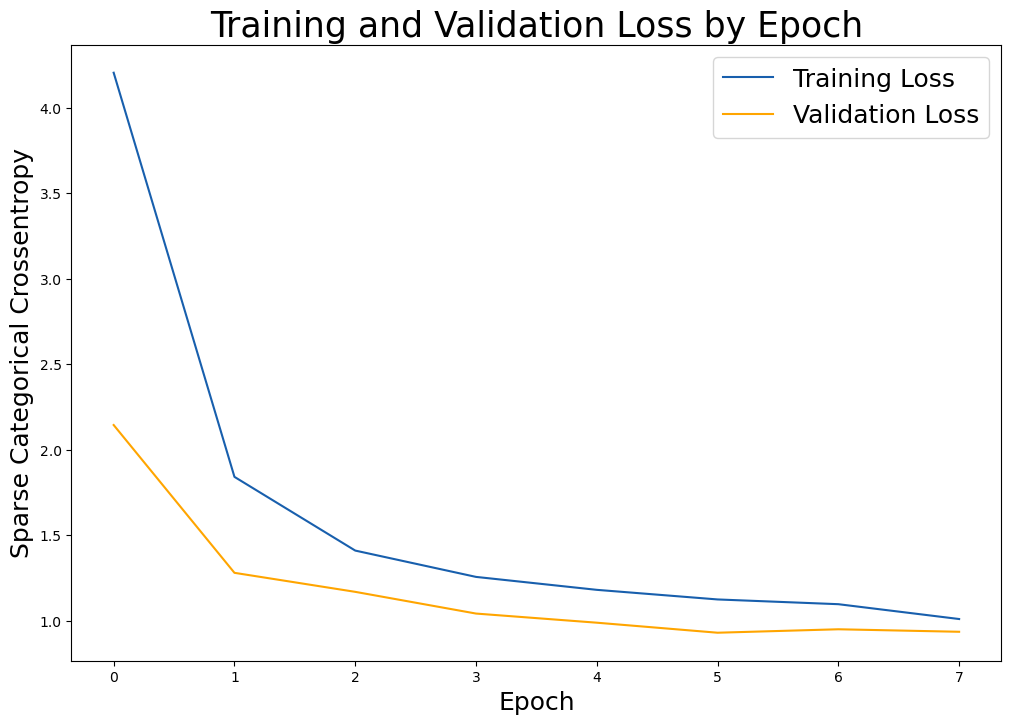

In [ ]:
# Check out our train accuracy and validation loss over epochs.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,8,1), range(0,8,1))

plt.legend(fontsize = 18)

In [ ]:
if train_model:
    model.save(model_name)
    # model.save_weights('my_model_weights.h5')

In [ ]:
true_speaker_ids = []
pred_speakers_ids = []
for audio, speaker in test_ds:
    preds = model(audio)
    test_ids = speaker.numpy().reshape(-1)
    true_speaker_ids.extend(speaker_encoder.inverse_transform(test_ids))
    for p in preds:
        speaker_ids = np.argmax(p.numpy().reshape(-1,1), axis=0)
        pred_speakers_ids.extend(speaker_encoder.inverse_transform(speaker_ids))

In [ ]:
true_pred_on_test=pd.DataFrame({'true_ids':true_speaker_ids,'pred_ids':pred_speakers_ids})
print('Checking how many files model got wrong speaker_id:')
wrong_ids = true_pred_on_test[true_pred_on_test['true_ids'] != true_pred_on_test['pred_ids']]
wrong_ids

Checking how many files model got wrong speaker_id:


,true_ids,pred_ids
5,1926,1553
26,3830,4640
31,6531,1970
75,6385,8324
160,1578,3879
...,...,...
3344,6209,5678
3361,6385,260
3377,4481,5456
3379,405,1334


In [ ]:
print('There are {} files model got wrong speaker_id.'.format(wrong_ids.shape[0]))

There are 158 files model got wrong speaker_id.


# Transfer Learning

**When use sign up, loading 10 new audio files, which server send, to training.**

In [12]:
DIR_NEW_DATA = '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com'

In [13]:
new_list_paths=[]
for r, d, f in os.walk(DIR_NEW_DATA):
    for file in f:
        if '.wav' in file:
            new_list_paths.append(os.path.join(r, file))

In [14]:
new_list_paths

['/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-0.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-1.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-2.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-3.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-4.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-5.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-6.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-7.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-8.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-9.wav',
 '/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-11.wav']

In [8]:
sample_test='/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-11.wav'
new_list_paths.pop(new_list_paths.index(sample_test))

'/content/drive/MyDrive/dataset/my-voice/nghiahieu@gm.com/nghiahieu@gm.com-11.wav'

In [ ]:
new_list_ds, new_speaker_ds = load_data(new_list_paths)
new_encoded_speaker_ds, new_speaker_encoder, new_unique_speakers = encoding_speaker(new_speaker_ds)

In [ ]:
# Audio (input) tensor is 3D tensor.
# 20x196 is MFCC encoding. Converting it to 3D for use in CNN layers.
# %time
new_audio_ds = create_audio_ds(new_list_ds)
# for a in audio_ds.take(1):
#     print(a.numpy().shape)

**Loading 50 old audio files, which saving before, use them like as different user label with new user.**

In [ ]:
old_audio = tf.data.experimental.load('/content/drive/MyDrive/dataset/audio_ds')

Labeling that data with value 0.

In [ ]:
old_complete_labeled_0 = tf.data.Dataset.zip((old_audio.shuffle(len(old_audio)).take(len(new_list_ds)*5),
                                              tf.data.Dataset.from_tensor_slices(np.repeat(0, len(new_list_ds)*5))))

In [ ]:
new_complete_labeled_ds = tf.data.Dataset.zip((new_audio_ds,
                                                tf.data.Dataset.from_tensor_slices(np.repeat(1,len(new_list_ds)))))

**Combine 2 dataset**

In [ ]:
# Finally, zip the input and labels to a single dataset.
# new_complete_labeled_ds = tf.data.Dataset.zip((new_audio_ds, new_encoded_speaker_ds))
new_complete_labeled_ds = new_complete_labeled_ds.concatenate(old_complete_labeled_0)

In [ ]:
BATCH_SIZE = 32
new_train_ds, new_val_ds, new_test_ds = train_dev_test_split(new_complete_labeled_ds, BATCH_SIZE)

new_input_shape = None
for audio, speaker in new_complete_labeled_ds.take(1):
    input_shape = audio.shape
    print('input_shape', audio.shape)
    print('output_shape', speaker.shape)


# labeled_ds = new_complete_labeled_ds
# data_size = sum([1 for _ in labeled_ds])
# train_size = int(data_size * 0.7)
# val_size = data_size - train_size
# labeled_ds = labeled_ds.shuffle(data_size, seed=42)
# new_train_ds = labeled_ds.take(train_size).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
# new_val_ds = labeled_ds.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(1)

all samples: 60
training samples: 42
validation samples: 12
test samples: 6
input_shape (20, 196, 1)
output_shape ()


**Create neư model corresponding to each users from old model.**

In [ ]:
model_path = '/kaggle/working/spr_model.h5'
old_model = keras.models.load_model(model_path)
# old_weights = old_model.load_weights('/kaggle/working/my_model_weights.h5')
# old_model = keras.Model(old_model.input, old_model.layers[-6].output)

In [ ]:
def layer_added(output_based_network, unique_speakers):
    dropout_rate = .25
    regularazation = 0.001
    x = output_based_network
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(unique_speakers * 2, activation='relu',
                  kernel_regularizer=keras.regularizers.l2(regularazation))(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(unique_speakers, activation='sigmoid', name='speaker')(x)
    return x

output_based_network = old_model.layers[-6].output
output_layer = layer_added(output_based_network, new_unique_speakers)
new_model = keras.Model(old_model.input, output_layer)
new_model.layers[-6].set_weights(old_model.layers[-6].get_weights())
new_model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 196, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 196, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 98, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 98, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 98, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 49, 32)        0  

In [ ]:
new_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['binary_accuracy'])

In [ ]:
# Freeze the first layers, before train it
for layer in new_model.layers[:-5]:
    layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(new_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 max_pooling2d False
3 batch_normalization False
4 conv2d_1 False
5 max_pooling2d_1 False
6 batch_normalization_1 False
7 conv2d_2 False
8 max_pooling2d_2 False
9 batch_normalization_2 False
10 flatten_16 True
11 dropout_53 True
12 dense_20 True
13 dropout_54 True
14 speaker True


In [ ]:
if train_model:
    root_logdir = os.path.join(os.curdir, "spr_logs")
    def get_run_dir():
        import time
        run_id = time.strftime("run%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)
    run_logdir = get_run_dir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, update_freq='batch')
    new_history = new_model.fit(new_train_ds, epochs=8, validation_data=new_val_ds, callbacks=[tensorboard_cb])

Epoch 1/8
2/2 [==============================] - 3s 1s/step - loss: 0.5666 - binary_accuracy: 0.9762 - val_loss: 0.5591 - val_binary_accuracy: 1.0000
Epoch 2/8
2/2 [==============================] - 2s 829ms/step - loss: 0.5941 - binary_accuracy: 0.9762 - val_loss: 0.6689 - val_binary_accuracy: 1.0000
Epoch 3/8
2/2 [==============================] - 2s 1s/step - loss: 0.5860 - binary_accuracy: 0.9762 - val_loss: 0.5023 - val_binary_accuracy: 1.0000
Epoch 4/8
2/2 [==============================] - 2s 1s/step - loss: 0.5737 - binary_accuracy: 1.0000 - val_loss: 0.5567 - val_binary_accuracy: 1.0000
Epoch 5/8
2/2 [==============================] - 2s 786ms/step - loss: 0.5452 - binary_accuracy: 0.9762 - val_loss: 0.5058 - val_binary_accuracy: 0.9167
Epoch 6/8
2/2 [==============================] - 2s 1s/step - loss: 0.5733 - binary_accuracy: 0.9762 - val_loss: 0.5005 - val_binary_accuracy: 1.0000
Epoch 7/8
2/2 [==============================] - 2s 1s/step - loss: 0.5590 - binary_accuracy: 

# Testing with the sample test and see the result

In [ ]:
sample_file = [sample_test]
sample_ds = tf.data.Dataset.from_tensor_slices(sample_file)
sample_input = create_audio_ds(sample_ds).batch(1)
output = new_model.predict(sample_input)


5/5 [==============================] - 0s 6ms/step


In [ ]:
output

array([[0.99903613],
       [0.99970734],
       [0.48221797],
       [0.48221797],
       [0.48221797]], dtype=float32)

In [ ]:
new_model.save('trans_l.h5')
new_model.save_weights('trans_l_weights.h5')